In [1]:
%%javascript
<!-- Ignore this block -->
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#%config InlineBackend.figure_format = 'retina'

from __future__ import division
import pandas as pd
from itertools import product
import numpy as np
from math import sqrt, isnan
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from mpl_toolkits.mplot3d import Axes3D

logDelta = 0.1e-6

## generatePearsonCoefficient Procedure
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/f76ccfa7c2ed7f5b085115086107bbe25d329cec">
For sample:-
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/bd1ccc2979b0fd1c1aec96e386f686ae874f9ec0">
For selecting some features and for dropping others I am using Pearson's Coefficient. The value of Pearson's coefficient lies between [-1, 1] and tells how two features are related<br>
<table>
<tr><td>Strength of Association</td><td>Positive</td><td>Negative</td></tr><tr><td>Small</td><td>.1 to .3  </td><td>-0.1 to -0.3  </td></tr><tr><td>Medium</td><td>.3 to .5  </td><td>-0.3 to -0.5  </td></tr><tr><td>Large</td><td>.5 to 1.0 </td><td>-0.5 to -1.0  </td></tr></table>


In [3]:
"""Generate pearson's coefficient"""

def generatePearsonCoefficient(A, B):
    A = A - A.mean()
    B = B - B.mean()
    return ((A * B).sum())/(sqrt((A * A).sum()) * sqrt((B * B).sum())) 

### TextEncoder

Here the data is mix of numbers and text. Text value cannot be directly used and should be converted to numeric data.<br>
For this I have created a function text encoder which accepts a pandas series. Text encoder returns a lookUp dictionary for recreating the numeric value for text value and encoded text vector.
For encoding I have applied a lambda function that will return value from dictionary.

In [4]:
""" Converts the text features into numeric values so that they can be used by 
the downstream algorithms. 
Accepts pandas series and returns lookup dictionary and encoded vector"""

def textEncoder(textVector):
    if type(textVector) == pd.core.series.Series:
        
        lookUpDictionary = {}
        lookupValue = 0
        for key in textVector.unique():
            lookUpDictionary[key] = lookupValue
            lookupValue +=1
        
        textVector = textVector.apply(lambda a: lookUpDictionary[a])
        return lookUpDictionary,textVector
            
        
    else:
        raise TypeError("Expected a pandas series as an input")   

## generateSpearmanCoefficient
https://en.m.wikipedia.org/wiki/Spearman's_rank_correlation_coefficient

If the data is categorical we cannot use pearson's coeffecient as it assumes that data comes from normal distribution.<br>
However Spearman's coefficient is appropriate for both continuous and discrete ordinal variables.<br>

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/a8dda555d22080d721679401fa13181cad3863f6"/>

This is same as pearson's coefficient applied to ranked values

In [5]:
def generateSpearmanCoefficient(x, y):
    
    """Rank the values"""
    n = len(x)
    xRanked = rankdata(x)
    yRanked = rankdata(y)
    
    """Generate Paerson's constant on ranked data"""
    return generatePearsonCoefficient(xRanked, yRanked)
    
    

## Feature scaling
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b0aa2e7d203db1526c577192f2d9102b718eafd5">

In [6]:
def scaleFeature(x):
    mean = np.mean(x)
    stdDeviation = np.std(x)
    return x.apply(lambda y: ((y * 1.0) - mean)/(stdDeviation))

## SplitDataSet Procedure
This method splits the dataset into trainset and testset based upon the trainSetSize value. For splitting the dataset, I am using pandas.sample to split the data. This gives me trainset. For testset I am calculating complement of the trainset. This I am doing by droping the index present in training set.

In [7]:
"""Splits the provided pandas dataframe into training and test dataset"""
def splitDataSet(inputDataframe, trainSetSize):
    
        trainSet = inputDataframe.sample(frac = trainSetSize)
        testSet = inputDataframe.drop(trainSet.index)
        return trainSet, testSet

## Logistic function
We are using sigmoid as a logistic function defined as <img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/9537e778e229470d85a68ee0b099c08298a1a3f6">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png">
This function calculates probabilities using sigmoid function


In [8]:
def logisticFunction(x):
    return 1.0/(1.0 + np.exp(-x))

## Regularization
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/d55221bf8c9b730ff7c4eddddb9473af47bb1d1c">

### L2 loss
L2 loss or Tikhonov regularization
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/7328255ad4abce052b3f6f39c43e974808d0cdb6">
Caution: Do not regularize B0 or bias term

In [9]:
def l2Loss(regularizationParameter, weight):
    loss = 2 * regularizationParameter * weight
    "Remove impact on bias"
    loss[0] = 0
    return loss

## Generate logLoss procedure
For binary classification
<img src="http://wiki.fast.ai/images/math/a/4/6/a4651d4ad311666c617d57c1dde37b28.png">

In [10]:
def logLoss(y, p):
    return -(y * np.log(p + logDelta) + (1 - y) * np.log(1 - p + logDelta)).sum()

## logisticSolverNewton

In [11]:
def logisticSolverNewton(x, y, beta, regularizationParameter = None, regularization = None):
    
    p = logisticFunction(np.dot(beta, x.T))
    gradient = np.dot(x.T, p - y)
    
    w = p * (1 - p)
    identity = np.identity(len(w))
    w = identity * w
    hessian = np.dot(np.dot(x.T, w), x)
 
    updateRule = None
    if regularization == None:
        updateRule = np.dot(np.linalg.inv(hessian), gradient) 
    else:
        regFactor = regularization(regularizationParameter, beta)
        updateRule = np.dot(np.linalg.inv(hessian + 2 * regularizationParameter * np.identity(len(hessian))) , 
                                    (gradient + regFactor))
    return updateRule
    
    
    

## miniBatchLogisticRegression
Here log loss is being used. The objective is minimization of loss.
X<sup>T</sup>(P-Y)

In [12]:
"""If no step length controller is provided then values of alpha will be taken as step length.
Else the step length controller will be used. Additional parameters to the controller are
provided by stepLengthControllerParameters"""

def miniBatchLogisticRegression(xTrain, yTrain, xTest, yTest, beta, epochs = 5, 
                             batchSize = 50, verbose = 0, alpha = 1.1e-5, 
                             regularizationParameter = 9e-2, regularization = None, solver = None):
    
    xTrain = np.insert(xTrain, 0, 1, axis = 1)
    xTest = np.insert(xTest, 0, 1, axis = 1)
    
    xTrain = xTrain * 1.0
    yTrain = yTrain * 1.0

    xTest = xTest * 1.0
    yTest = yTest * 1.0

    
    """For plotting graphs"""
    logLossTraining = []
    logLossTest = []
    
    indices = np.array(range(0, len(xTrain)))
    for i in range(0, epochs):
        
        if verbose:
            print("Epoch-"+str(i))
        
        
        """Shuffle the indices"""                        
        np.random.shuffle(indices)
        
        """Will split. May be uneven"""
        batches = np.array_split(indices, batchSize)
        
        if verbose:
            print("Total batches created"+str(len(batches)))
        
        index = 0
        while index < len(xTrain):
            
            batch = indices[index : index + batchSize]
            index = index + batchSize
            
            """Select required x and y subsets"""
            x = np.take(xTrain, batch, axis = 0)
            y = np.take(yTrain, batch, axis = 0)
            
            p = logisticFunction(np.dot(beta, x.T))
            gradient = np.dot(x.T, p - y)
        
            if solver == None:
                
                """Gradient descent"""
                regFactor = 0
                if regularization != None:
                    regFactor = regularization(regularizationParameter, beta)
                
                beta = beta - (alpha * (gradient + regFactor))
            else:
                beta = beta - (alpha * solver(x, y, beta, regularizationParameter, regularization))               
        
        if verbose:
            print beta
        
        """Calculating LogLoss for train and test set"""
        xTrainPrediction = np.dot(beta, xTrain.T)
        xTestPrediction = np.dot(beta, xTest.T)
        
        logLossTraining.append(logLoss(yTrain, logisticFunction(np.dot(beta, xTrain.T))))
        logLossTest.append(logLoss(yTest, logisticFunction(np.dot(beta, xTest.T))))
    return beta, logLossTraining, logLossTest

## kFoldAnalysis

In [13]:
def kFoldAnalysis(xTrain, yTrain, model, modelParameters, nFolds):
    
    indices = np.array(range(0, len(xTrain)))
    folds = np.array_split(indices, nFolds)
    
    analysisMetricList = []
    trainLossList = []
    testLossList = []
    
    for i in range(0, len(folds)):
        validationSet = folds[i]
        
        """Set difference"""
        trainSet = np.setdiff1d(indices, validationSet)
        
        modelParameters['xTrain'] = np.take(xTrain, trainSet, axis = 0)
        modelParameters['yTrain'] = np.take(yTrain, trainSet, axis = 0)
        modelParameters['xTest'] = np.take(xTrain, validationSet, axis = 0)
        modelParameters['yTest'] = np.take(yTrain, validationSet, axis = 0)
        
        modelParams, trainLoss, testLoss = model(**modelParameters)
        analysisMetricList.append(testLoss[-1])
        trainLossList.append(trainLoss)
        testLossList.append(testLoss)
        
    return modelParams, trainLossList, testLossList, analysisMetricList
    

## GridSearch

In [14]:
def gridSearch(xTrain, yTrain, xTest, yTest, model, modelParameters, hyperParameters, 
               nFolds = 1, reTrain = True, plotGraphs = False):
    
    """For storing is the best parameters"""
    leastLoss = None
    bestModel = None
    bestHyperParams = None
    
    """Generate the parameter grid"""
    parameterGrid = []
    gridKeys = []
    
    parameterGrid = list(product(*hyperParameters.values()))
    hyperParameterKeys = hyperParameters.keys()
    
    """For plottong graphs"""
    if plotGraphs:
        plt.close()
        plotHeight = 10
        plotWidth = 20
        index = 0
        fig, axs = plt.subplots(len(parameterGrid), 2, figsize=(plotWidth, plotHeight * len(parameterGrid)))
        fig = plt.figure()
        fig.set_figheight(15)
        fig.set_figwidth(15)
        ax = fig.add_subplot(111, projection='3d')
 

    """Grid search for cartesian product of hyperParameters"""    
    for parameterMesh in parameterGrid:
        hyperParameterMesh = {}
        for k,v in zip(hyperParameterKeys, parameterMesh):
            hyperParameterMesh[k] = v
        
        """Combine model Parameters"""
        updatedParam = modelParameters.copy()
        updatedParam.update(hyperParameterMesh)
        
        """Perform grid search with cross validation"""
        if nFolds > 1:
            modelParams, trainLossList, testLossList, analysisMetricList = kFoldAnalysis(model = model,
                                                                                        xTrain = xTrain,
                                                                                        yTrain = yTrain,
                                                                                        nFolds = nFolds,
                                                                                        modelParameters = updatedParam)  
            
            
            """For storing best model"""
            avg = np.average(analysisMetricList)
            if leastLoss == None or avg < leastLoss:
                leastLoss = avg
                bestModel = modelParams
                bestHyperParams = hyperParameterMesh
            
            """For plotting"""
            if plotGraphs:
                foldIndex = 1

                ax.scatter(hyperParameterMesh['alpha'], hyperParameterMesh['regularizationParameter'], 
                           avg, marker = 'o', label = str(hyperParameterMesh))
 

                for train, test in zip(trainLossList, testLossList):
                    axs[index][0].plot(train, label = "Fold-" + str(foldIndex))
                    axs[index][1].plot(test, label = "Fold-" + str(foldIndex))
                    foldIndex = foldIndex + 1
                
                axs[index][0].legend()
                axs[index][0].grid()
                
                axs[index][1].legend()
                axs[index][1].grid()
                
                axs[index][0].set_title("Train set for " + str(hyperParameterMesh))
                axs[index][1].set_title("Validation set for " + str(hyperParameterMesh))
                
                index = index + 1
            
                
            """Perform only grid search and no cross validation. Test set will be used for validation"""    
        else:
            trainedModel, trainLoss, testLoss = model(xTrain, yTrain, xTest, yTest, **updatedParam)
            
            """For storing best model"""
            if leastLoss == None or testLoss[-1] < leastLoss:
                leastLoss = testLoss[-1]
                bestModel = trainedModel
                bestHyperParams = hyperParameterMesh
            
            """For plotting graphs"""
            if plotGraphs:
                axs[index][0].plot(trainLoss, label = "Training set Loss for " + str(hyperParameterMesh))
                axs[index][0].legend()
                axs[index][0].grid()
                axs[index][1].plot(testLoss, label = "Test set Loss for " + str(hyperParameterMesh))
                axs[index][1].legend()
                axs[index][1].grid()
                index = index + 1
    
    if plotGraphs:
        ax.legend()
        ax.set_xlabel('alpha')
        ax.set_ylabel('regularizationParameter')
        ax.set_zlabel('RMSE')

        plt.show()
        plt.close()
    
    if reTrain:
        
        """Combine model Parameters"""
        updatedParam = modelParameters.copy()
        updatedParam.update(bestHyperParams)

        bestModel, trainLoss, testLoss = model(xTrain, yTrain, xTest, yTest, **updatedParam)
        print trainLoss[-1]
        print testLoss[-1]
        
        if plotGraphs:
            plt.close()
            plotHeight = 10
            plotWidth = 20
            fig, axs = plt.subplots(1, 2, figsize = (plotWidth, plotHeight)) 
            
            plt.suptitle("Best model")

            axs[0].plot(trainLoss, label = "Training set Loss for " + str(bestHyperParams))
            axs[0].legend()
            axs[0].grid()
            axs[1].plot(testLoss, label = "Test set Loss for " + str(bestHyperParams))
            axs[1].legend()
            axs[1].grid()
        
            plt.show()
        
        
    
    return bestModel, bestHyperParams

## Get quadratic variables

In [15]:
def getQuadraticDerivedVariables(inputDataFrame, keys, degree):
    newKeys = []
    for key in keys:
        inputDataFrame[key+" Degree-" + str(degree)] = inputDataFrame[key] ** degree
        newKeys.append(key+" Degree-" + str(degree))
    return newKeys

## Make Prediction

In [16]:
def predict(modelParameters, x):
    x = np.insert(x, 0, 1, axis = 1)
    x = x * 1
    return np.dot(modelParameters, x.T)

## Checking prediction

In [17]:
def predictionBinaryClassifier(x, beta):
    """Add bias to x"""
    x = np.insert(x, 0, 1, axis = 1)
    probability = logisticFunction(np.dot(beta, x.T))
    func = np.vectorize(lambda x: 1 if x >=0.5 else 0)
    probability = func(probability)
    return probability

## Bank marketing dataset

### Load dataset

In [18]:
""" File path change accordingly"""
directoryPath = "Data"

bankMarketingData = pd.read_csv(directoryPath+"/bank.csv", sep=";")
bankMarketingData.head()

age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no

In [19]:
bankMarketingData.describe().T

count         mean          std     min    25%    50%     75%  \
age       4521.0    41.170095    10.576211    19.0   33.0   39.0    49.0   
balance   4521.0  1422.657819  3009.638142 -3313.0   69.0  444.0  1480.0   
day       4521.0    15.915284     8.247667     1.0    9.0   16.0    21.0   
duration  4521.0   263.961292   259.856633     4.0  104.0  185.0   329.0   
campaign  4521.0     2.793630     3.109807     1.0    1.0    2.0     3.0   
pdays     4521.0    39.766645   100.121124    -1.0   -1.0   -1.0    -1.0   
previous  4521.0     0.542579     1.693562     0.0    0.0    0.0     0.0   

              max  
age          87.0  
balance   71188.0  
day          31.0  
duration   3025.0  
campaign     50.0  
pdays       871.0  
previous     25.0

### Encoding y values and dropping the duration column. 
The reason for dropping this column is that we do not know the duration of call before hand

In [20]:
"""Encoding the outcome values using text encoder"""
yLookUpDictionary, bankMarketingData['y'] = textEncoder(bankMarketingData['y'])


"""Dropping duration as it will not be known beforehand while predicting"""
bankMarketingData = bankMarketingData.drop('duration', axis = 1)

In [21]:
bankMarketingData.dropna(inplace = True)
bankMarketingData.head()

age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  campaign  pdays  previous poutcome  y  
0  cellular   19   oct         1     -1         0  unknown  0  
1  cellular   11   may         1    339         4  failure  0  
2  cellular   16   apr         1    330         1  failure  0  
3   unknown    3   jun         4     -1         0  unknown  0  
4   unknown    5   may         1     -1         0  unknown  0

### Using quadratic model

In [22]:
numericalFeatures = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']

In [23]:
derivedFeaturesDegreeTwo = getQuadraticDerivedVariables(bankMarketingData, numericalFeatures, 2)
derivedFeaturesDegreeThree = getQuadraticDerivedVariables(bankMarketingData, numericalFeatures, 3)


numericalFeatures.extend(derivedFeaturesDegreeTwo)
numericalFeatures.extend(derivedFeaturesDegreeThree)

bankMarketingData.head()

age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day        ...         day Degree-2  campaign Degree-2  \
0  cellular   19        ...                  361                  1   
1  cellular   11        ...                  121                  1   
2  cellular   16        ...                  256                  1   
3   unknown    3        ...                    9                 16   
4   unknown    5        ...                   25                  1   

   pdays Degree-2  previous Degree-2 age Degree-3  balance Degree-3  \
0               1                  0        27000        5706550403   
1          114921                 16        35937      109833421069   
2          108900                  1        42875        2460375000   
3               1                  0        27000        3215578176   
4               1                  0       205379                 0   

   day Degree-3  campaign Degree-3  pdays Degree-3  previous Degree-3  
0          6859                  1              -1                  0  
1          1331                  1        38958219                 64  
2          4096                  1        35937000                  1  
3            27                 64              -1                  0  
4           125                  1              -1                  0  

[5 rows x 28 columns]

### Feature scaling

In [24]:
for feature in numericalFeatures:
    bankMarketingData[feature] = scaleFeature(bankMarketingData[feature])

bankMarketingData.head()

age          job  marital  education default   balance housing loan  \
0 -1.056270   unemployed  married    primary      no  0.121072      no   no   
1 -0.772583     services  married  secondary      no  1.118644     yes  yes   
2 -0.583458   management   single   tertiary      no -0.024144     yes   no   
3 -1.056270   management  married   tertiary      no  0.017726     yes  yes   
4  1.686036  blue-collar  married  secondary      no -0.472753     yes   no   

    contact       day        ...         day Degree-2  campaign Degree-2  \
0  cellular  0.374052        ...             0.143306          -0.221065   
1  cellular -0.596026        ...            -0.723144          -0.221065   
2  cellular  0.010273        ...            -0.235766          -0.221065   
3   unknown -1.566105        ...            -1.127487          -0.019769   
4   unknown -1.323585        ...            -1.069724          -0.221065   

   pdays Degree-2  previous Degree-2 age Degree-3  balance Degree-3  \
0       -0.299977          -0.140180    -0.808155         -0.038682   
1        2.671248           0.569165    -0.682375         -0.019994   
2        2.515576          -0.095846    -0.584729         -0.039264   
3       -0.299977          -0.140180    -0.808155         -0.039129   
4       -0.299977          -0.140180     1.702358         -0.039706   

   day Degree-3  campaign Degree-3  pdays Degree-3  previous Degree-3  
0     -0.056578          -0.091909       -0.187146          -0.073473  
1     -0.718537          -0.091909        1.643048           0.067538  
2     -0.387438          -0.091909        1.501116          -0.071270  
3     -0.874686          -0.068218       -0.187146          -0.073473  
4     -0.862951          -0.091909       -0.187146          -0.073473  

[5 rows x 28 columns]

### Checking corelation

In [25]:
""" Here we CANNOT USE Pearson's corelation constant. This is because the target values
are categorical. The pearson's constant makes an assumption that variables belong to normal distribution.
This is not true for categorical data. Instead we will use Spearman's corelation to check corelation
discrete variables and categorical values of y """


for feature in numericalFeatures:
    print("The Spearman's corelation constant between " + feature + " and y is " + str(generateSpearmanCoefficient(bankMarketingData[feature], bankMarketingData['y'])))


The Spearman's corelation constant between age and y is 0.0162709406632
The Spearman's corelation constant between balance and y is 0.0789820266863
The Spearman's corelation constant between day and y is -0.0118109344463
The Spearman's corelation constant between campaign and y is -0.0646118031092
The Spearman's corelation constant between pdays and y is 0.150178680673
The Spearman's corelation constant between previous and y is 0.165332658801
The Spearman's corelation constant between age Degree-2 and y is 0.0162709406632
The Spearman's corelation constant between balance Degree-2 and y is 0.0809360244263
The Spearman's corelation constant between day Degree-2 and y is -0.0118109344463
The Spearman's corelation constant between campaign Degree-2 and y is -0.0646118031092
The Spearman's corelation constant between pdays Degree-2 and y is 0.14765921402
The Spearman's corelation constant between previous Degree-2 and y is 0.165332658801
The Spearman's corelation constant between age Degr

We will drop age, balance, day, campaign, age Degree-2, balance Degree-2, day Degree-2, campaign Degree-2

In [26]:
#numericalFeatures.remove('age')
#numericalFeatures.remove('balance')
#numericalFeatures.remove('day')
#numericalFeatures.remove('campaign')
#numericalFeatures.remove('age Degree-2')
#numericalFeatures.remove('balance Degree-2')
#numericalFeatures.remove('day Degree-2')
#numericalFeatures.remove('campaign Degree-2')
#print numericalFeatures

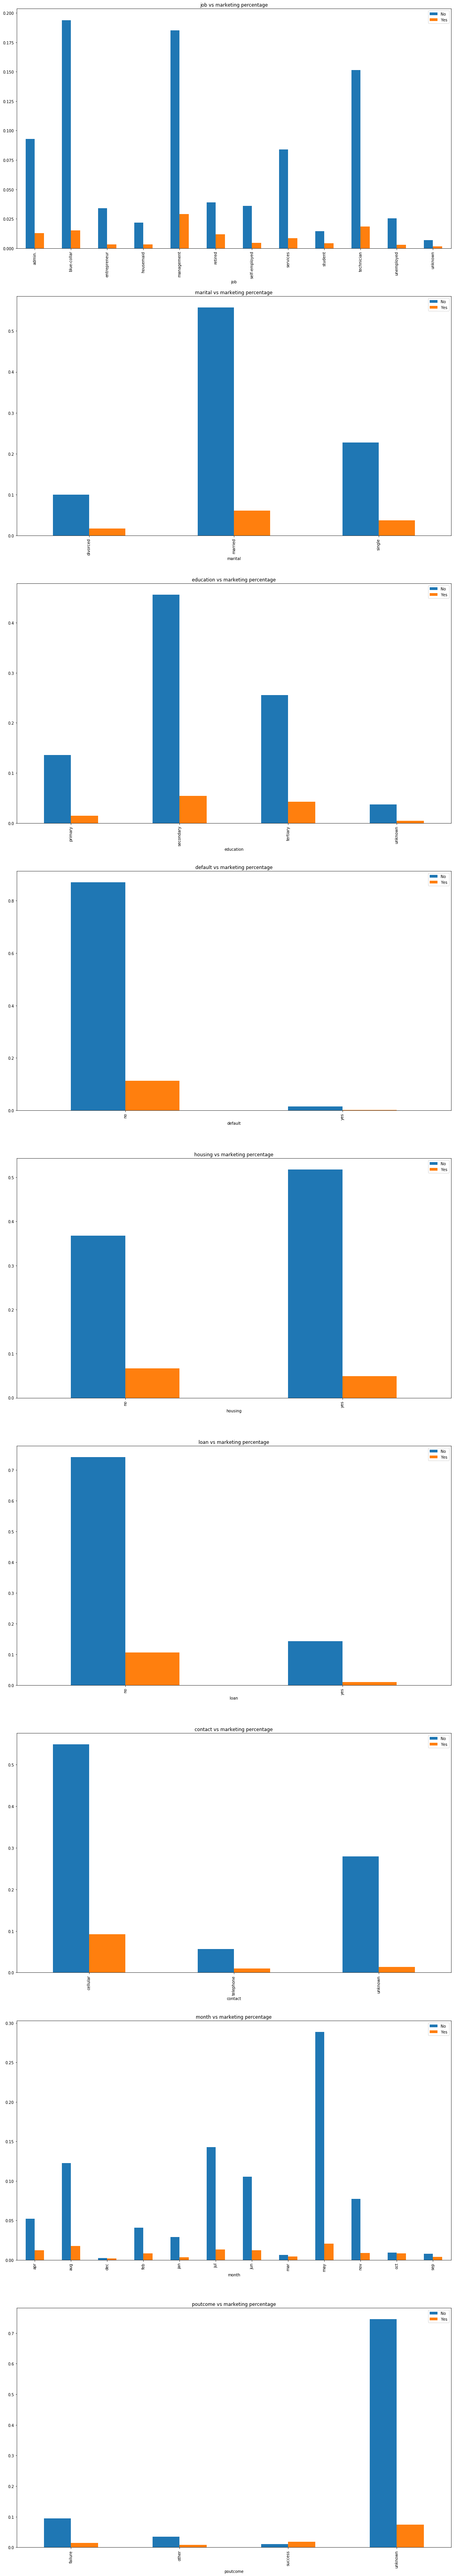

In [27]:
fig, axs = plt.subplots(9, 1, figsize=(20, 120))
axs = axs.flatten()
index = 0

categoricalfeatures = ['job', 'marital', 'education', 'default', 
                       'housing', 'loan', 'contact', 'month', 'poutcome']

for feature in categoricalfeatures:
    
    (bankMarketingData.groupby([feature, 'y']).size()/len(bankMarketingData)).unstack().plot(kind = 'bar', 
                                                                                             stacked = False, ax = axs[index], title = feature + " vs marketing percentage")
    axs[index].legend(['No', 'Yes'])
    index = index + 1
        
plt.show()
plt.close()

In [28]:
numericalFeatures.extend(categoricalfeatures)
totalFeatures = numericalFeatures
totalFeatures.append('y')
print totalFeatures

['age', 'balance', 'day', 'campaign', 'pdays', 'previous', 'age Degree-2', 'balance Degree-2', 'day Degree-2', 'campaign Degree-2', 'pdays Degree-2', 'previous Degree-2', 'age Degree-3', 'balance Degree-3', 'day Degree-3', 'campaign Degree-3', 'pdays Degree-3', 'previous Degree-3', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


In [29]:
bankMarketingData = bankMarketingData[totalFeatures]
bankMarketingData.head()

age   balance       day  campaign     pdays  previous  age Degree-2  \
0 -1.056270  0.121072  0.374052 -0.576829 -0.407218 -0.320413     -0.943494   
1 -0.772583  1.118644 -0.596026 -0.576829  2.989044  2.041734     -0.746848   
2 -0.583458 -0.024144  0.010273 -0.576829  2.899143  0.270124     -0.605346   
3 -1.056270  0.017726 -1.566105  0.387967 -0.407218 -0.320413     -0.943494   
4  1.686036 -0.472753 -1.323585 -0.576829 -0.407218 -0.320413      1.741923   

   balance Degree-2  day Degree-2  campaign Degree-2 ...          job  \
0         -0.085538      0.143306          -0.221065 ...   unemployed   
1          0.128576     -0.723144          -0.221065 ...     services   
2         -0.100406     -0.235766          -0.221065 ...   management   
3         -0.096544     -1.127487          -0.019769 ...   management   
4         -0.120173     -1.069724          -0.221065 ...  blue-collar   

   marital  education  default  housing  loan   contact  month poutcome  y  
0  married    primary       no       no    no  cellular    oct  unknown  0  
1  married  secondary       no      yes   yes  cellular    may  failure  0  
2   single   tertiary       no      yes    no  cellular    apr  failure  0  
3  married   tertiary       no      yes   yes   unknown    jun  unknown  0  
4  married  secondary       no      yes    no   unknown    may  unknown  0  

[5 rows x 28 columns]

In [30]:
bankMarketingData = pd.get_dummies(bankMarketingData)
bankMarketingData.head()

age   balance       day  campaign     pdays  previous  age Degree-2  \
0 -1.056270  0.121072  0.374052 -0.576829 -0.407218 -0.320413     -0.943494   
1 -0.772583  1.118644 -0.596026 -0.576829  2.989044  2.041734     -0.746848   
2 -0.583458 -0.024144  0.010273 -0.576829  2.899143  0.270124     -0.605346   
3 -1.056270  0.017726 -1.566105  0.387967 -0.407218 -0.320413     -0.943494   
4  1.686036 -0.472753 -1.323585 -0.576829 -0.407218 -0.320413      1.741923   

   balance Degree-2  day Degree-2  campaign Degree-2        ...         \
0         -0.085538      0.143306          -0.221065        ...          
1          0.128576     -0.723144          -0.221065        ...          
2         -0.100406     -0.235766          -0.221065        ...          
3         -0.096544     -1.127487          -0.019769        ...          
4         -0.120173     -1.069724          -0.221065        ...          

   month_jun  month_mar  month_may  month_nov  month_oct  month_sep  \
0          0          0          0          0          1          0   
1          0          0          1          0          0          0   
2          0          0          0          0          0          0   
3          1          0          0          0          0          0   
4          0          0          1          0          0          0   

   poutcome_failure  poutcome_other  poutcome_success  poutcome_unknown  
0                 0               0                 0                 1  
1                 1               0                 0                 0  
2                 1               0                 0                 0  
3                 0               0                 0                 1  
4                 0               0                 0                 1  

[5 rows x 63 columns]

### Split dataset

In [31]:
trainSet, testSet = splitDataSet(bankMarketingData, 0.8)

In [32]:
yTrain = trainSet['y']
yTest = testSet['y']

trainSet = trainSet.drop('y', axis = 1)
testSet = testSet.drop('y', axis = 1)


xTrain = trainSet.as_matrix()
xTest = testSet.as_matrix()

### Regularized vs non regularized model

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3820176190>
1206.71768651
1206.73102762
1106.9988055
1106.88624557


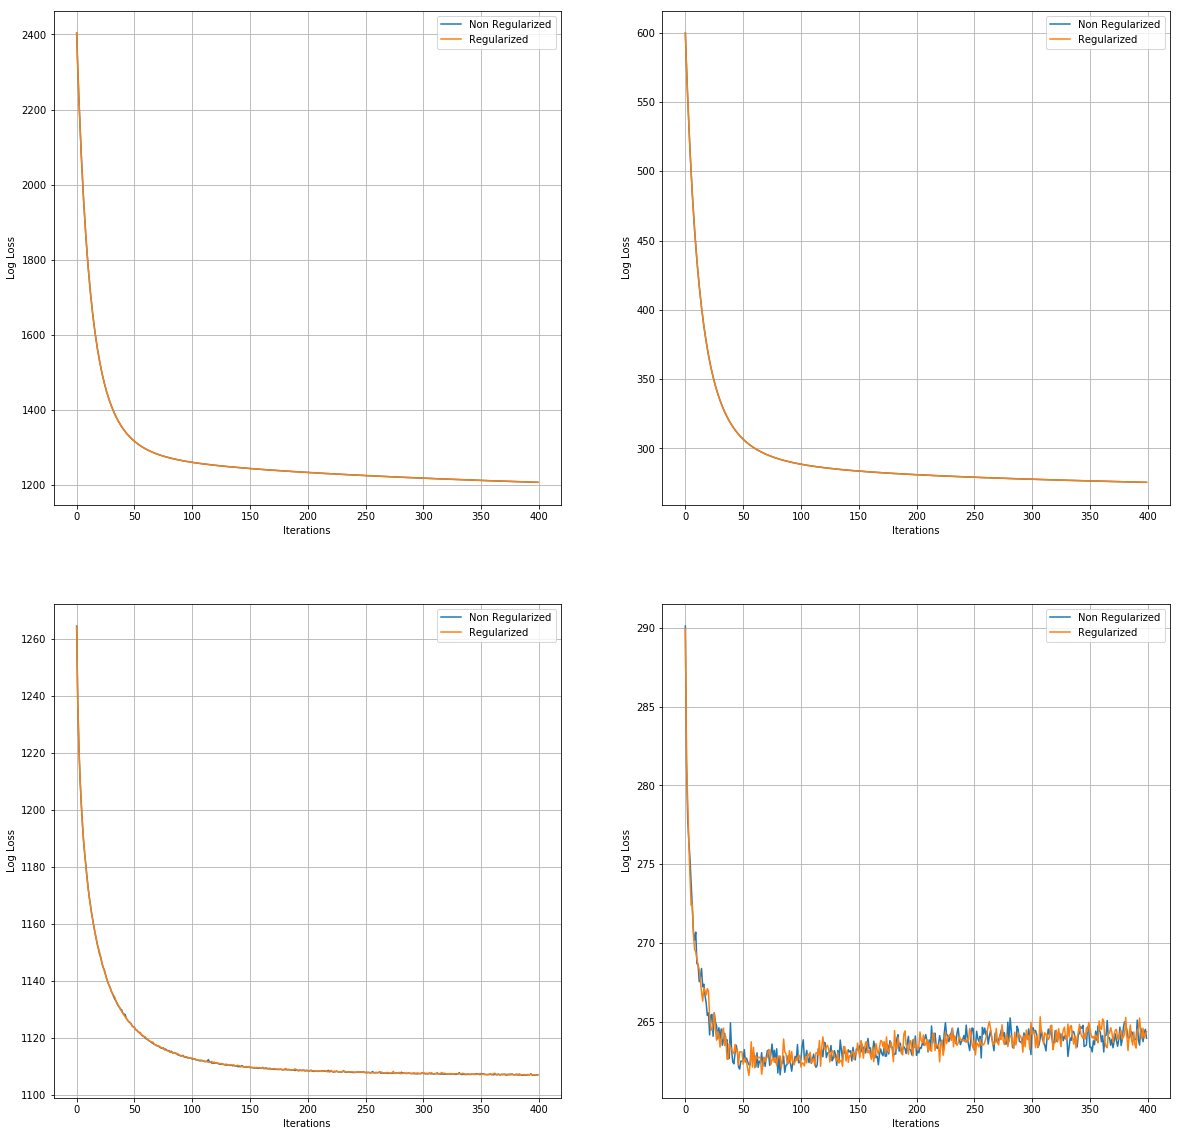

In [43]:
plt.close()


modelParameters = {"beta":np.zeros(xTrain.shape[1] + 1), "epochs":400, 
                   "batchSize":50, "verbose":0}

alphaList = [1e-5, 9e-4]
regularizationParameterList = [9e-4, 9e-4]

"""For plotting traph"""
plotHeight = 10
plotWidth = 20
index = 0
fig, axs = plt.subplots(len(alphaList), 2, figsize=(plotWidth, plotHeight * len(alphaList)))
print axs
for alpha, regularizationParameter in zip(alphaList, regularizationParameterList):
    betaNonReg, trainLossNonReg, testLossNonReg = miniBatchLogisticRegression(xTrain, yTrain, xTest, yTest,
                                                                           alpha = alpha, **modelParameters)
    
    betaReg, trainLossReg, testLossReg = miniBatchLogisticRegression(xTrain, yTrain, xTest, yTest,
                                                                           alpha = alpha, regularization = l2Loss,
                                                                      regularizationParameter = regularizationParameter,
                                                                      **modelParameters)
    
    print trainLossNonReg[-1]
    print trainLossReg[-1]
    axs[index][0].set_xlabel("Iterations")
    axs[index][1].set_xlabel("Iterations")

    axs[index][0].set_ylabel("Log Loss")
    axs[index][1].set_ylabel("Log Loss")
    
    
    axs[index][0].plot(trainLossNonReg, label = "Non Regularized")
    axs[index][0].plot(trainLossReg, label = "Regularized")
    axs[index][0].grid()
    axs[index][0].legend()

    
    axs[index][1].plot(testLossNonReg, label = "Non Regularized")
    axs[index][1].plot(testLossReg, label = "Regularized")
    axs[index][1].grid()
    axs[index][1].legend()
    index = index + 1


plt.show()    

A bad value of regularization parameter results into diverging rather than converging graph. This is evident in the third graph.
It is very difficult to calculate hyper parameters in this way.
Hence we use grid search.

### Using grid search with k-fold 
Here plotting takes some time. Make plotGraphs as false to avoid plotting of graphs

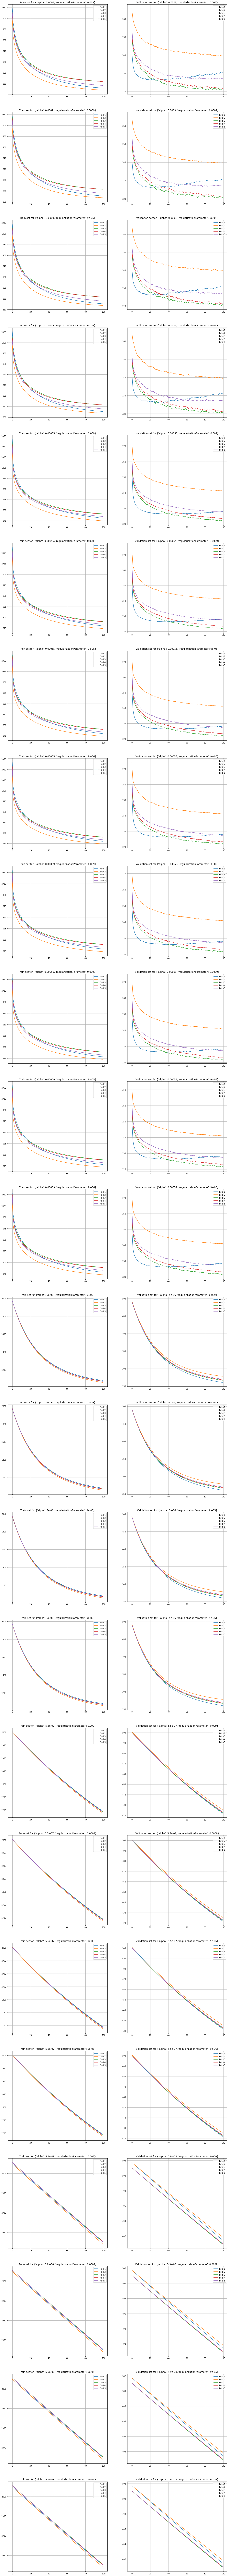

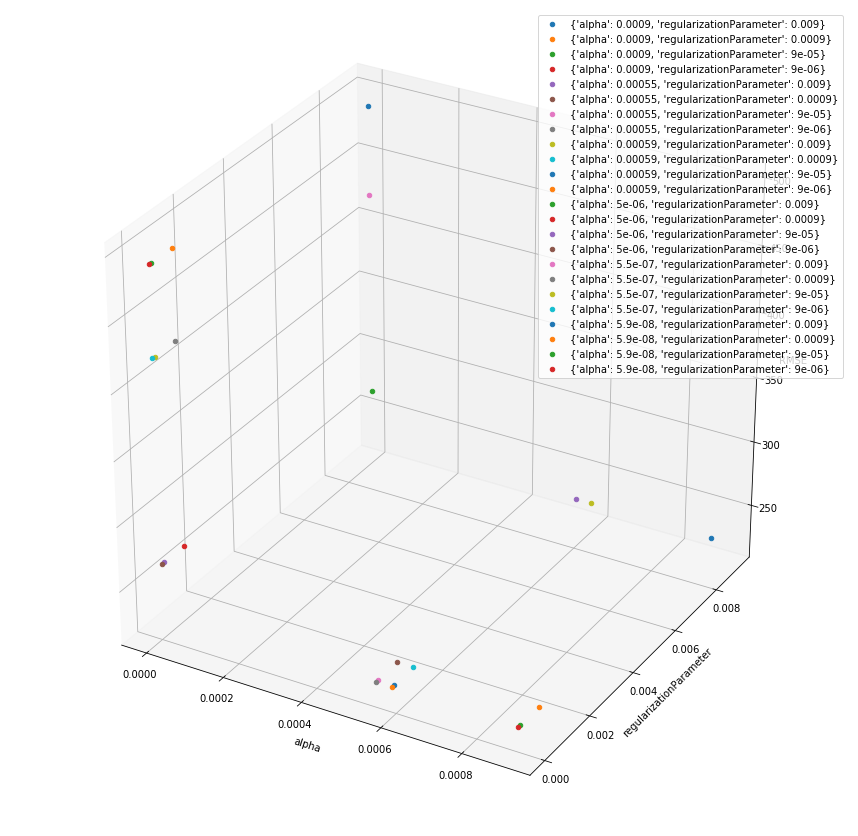

1097.46920329
277.677007668


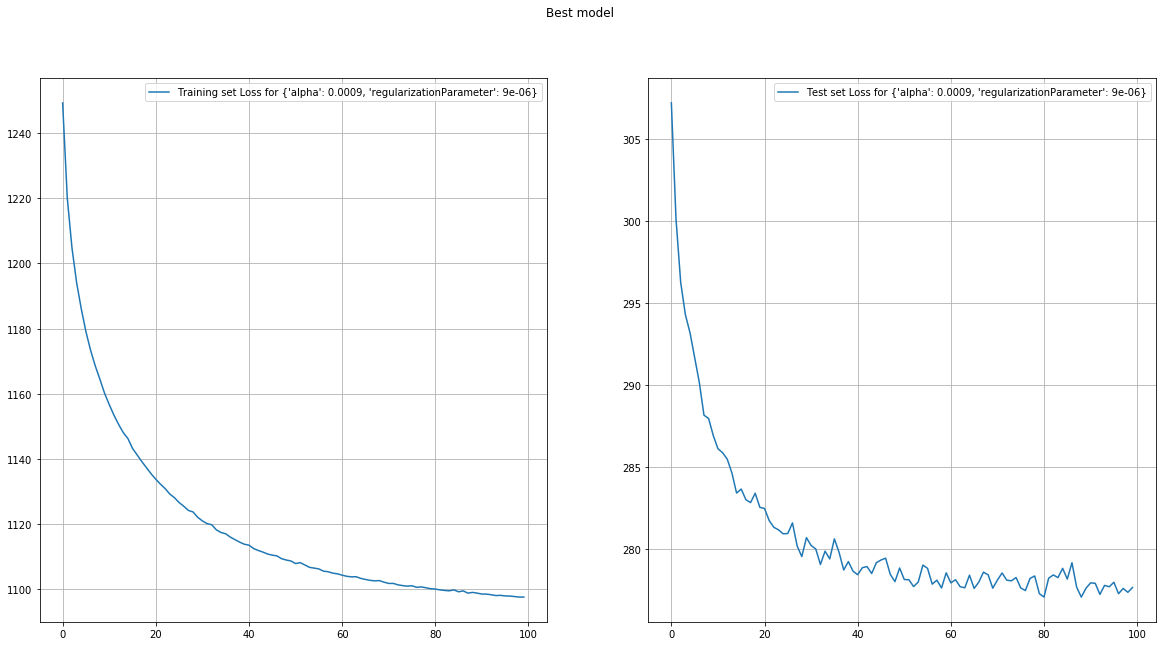

In [34]:
gridParameters = {
    "alpha":[9.0e-4, 5.5e-4, 5.9e-4, 5.0e-6, 5.5e-7, 5.9e-8],
    "regularizationParameter":[9e-3, 9e-4, 9e-5, 9e-6]
}


modelParameters = {
    "beta":np.zeros(xTrain.shape[1] + 1), 
    "epochs":100, 
    "batchSize":50, 
    "verbose":0,
    "regularization" : l2Loss
}

model, hyperParams = gridSearch(xTrain, yTrain, xTest, yTest, 
           miniBatchLogisticRegression, modelParameters, 
           gridParameters, nFolds = 5, reTrain = True, plotGraphs = True)

In [39]:
prediction = predictionBinaryClassifier(xTest, model)
df = pd.DataFrame({'true':yTest, 'predicted':prediction})
df.head(25)

NameError: name 'model' is not defined

In [36]:
"""Using only for reporting"""

from sklearn.metrics import classification_report

print classification_report(yTest, prediction)

             precision    recall  f1-score   support

          0       0.90      0.98      0.94       805
          1       0.54      0.15      0.24        99

avg / total       0.86      0.89      0.86       904



### Newton's method for logistic regression

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


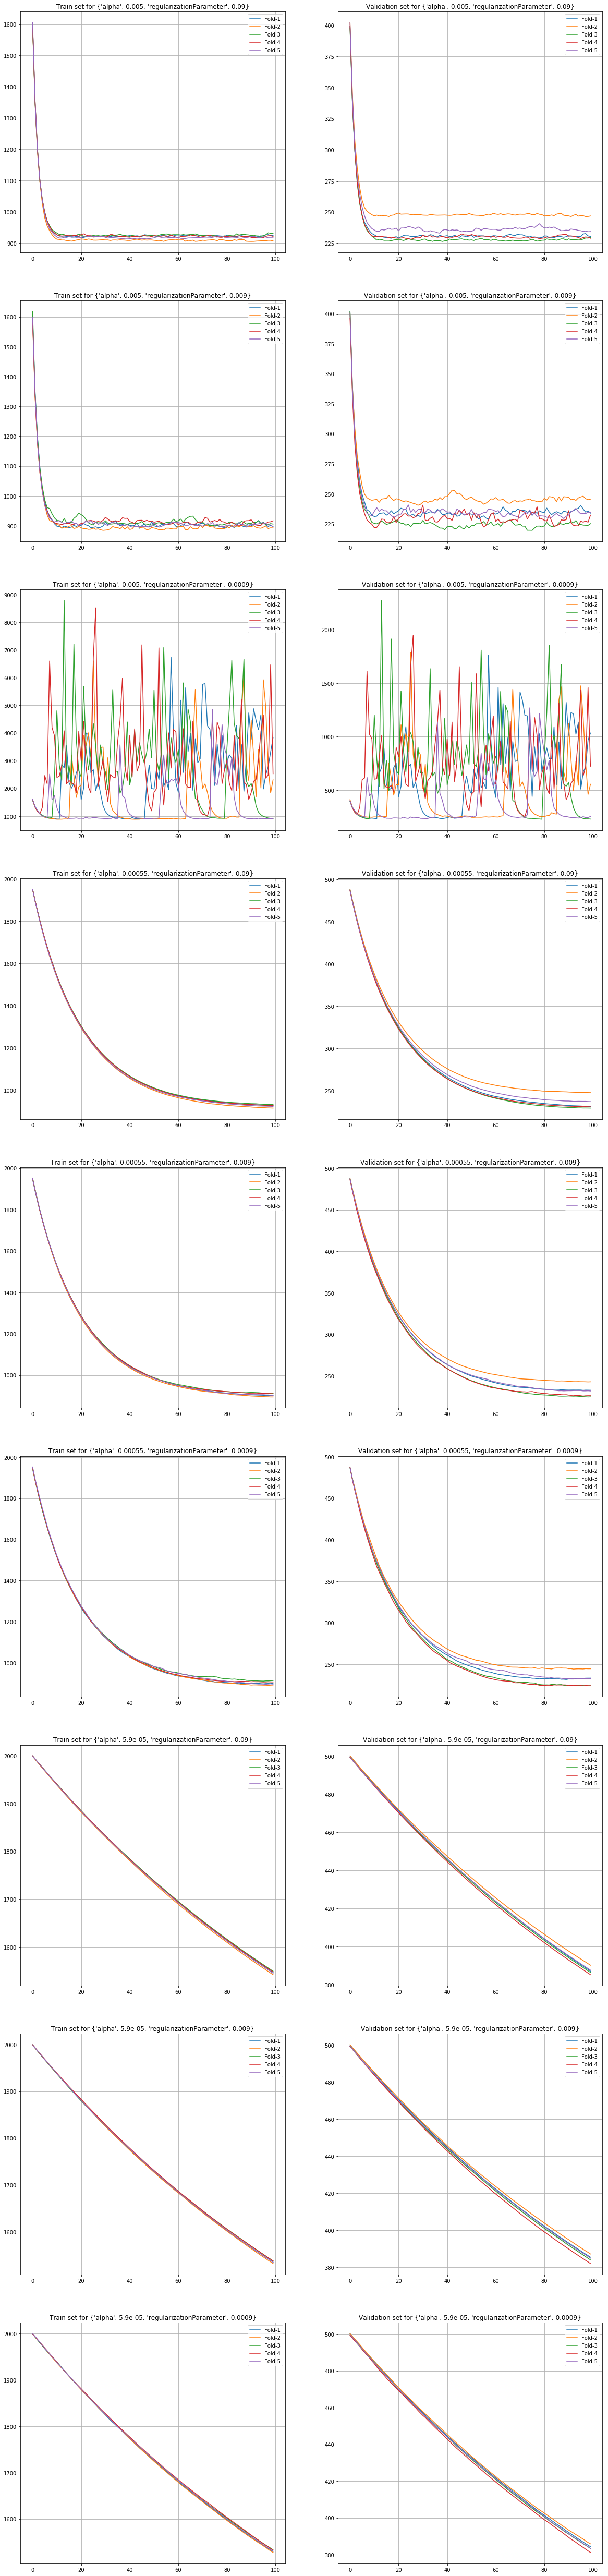

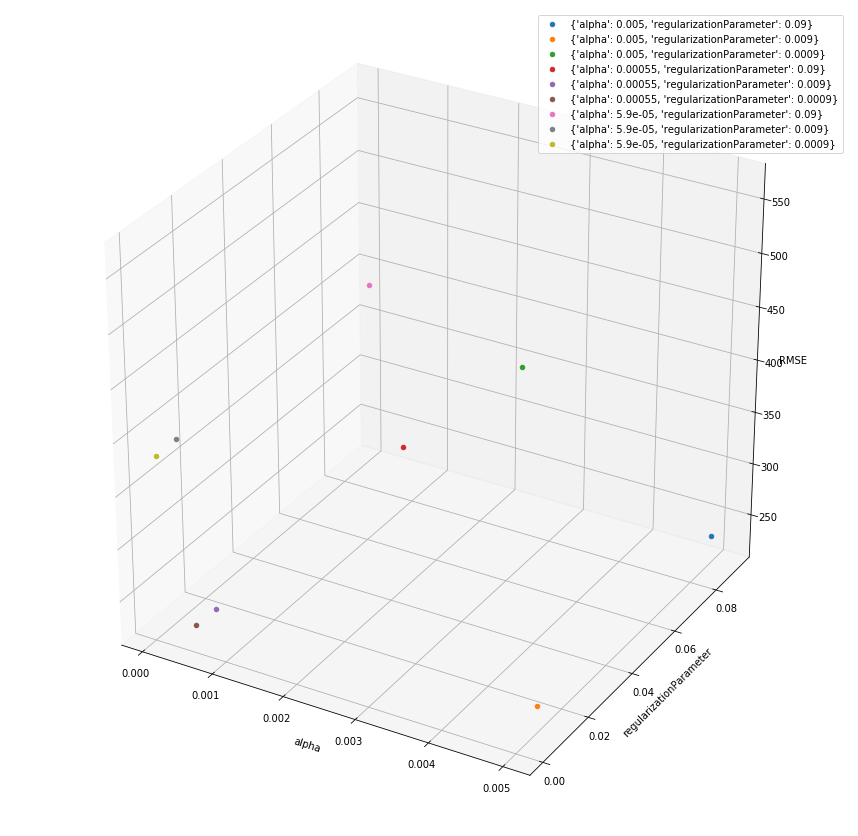

1125.33641886
279.495861818


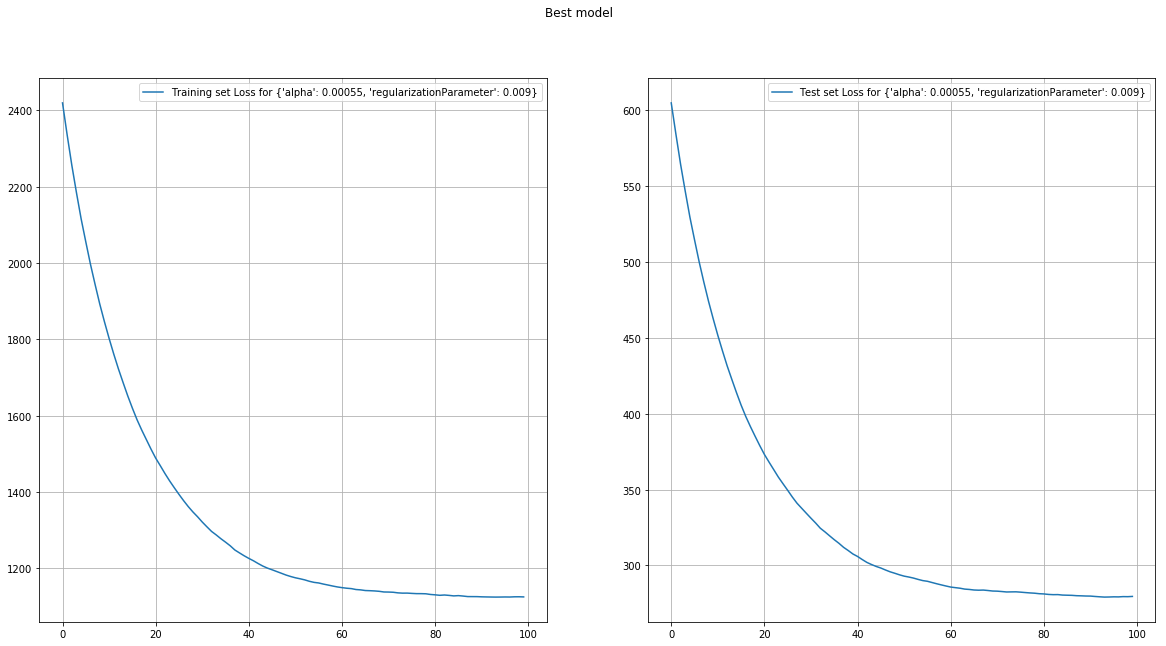

In [37]:
gridParameters = {
    "alpha" : [5.0e-3, 5.5e-4, 5.9e-5],
    "regularizationParameter" : [9e-2, 9e-3, 9e-4]
}

"""Set solvver as Newton for solving using Newton's method"""
modelParameters = {
    "beta":np.zeros(xTrain.shape[1] + 1), 
    "epochs":100, 
    "batchSize":50, 
    "verbose":0,
    "regularization" : l2Loss,
    "solver" : logisticSolverNewton
}

model, hyperParams = gridSearch(xTrain, yTrain, xTest, yTest, 
           miniBatchLogisticRegression, modelParameters, 
           gridParameters, nFolds = 5, reTrain = True, plotGraphs = True)

In [38]:
prediction = predictionBinaryClassifier(xTest, model)
df = pd.DataFrame({'true':yTest, 'predicted':prediction})
df.head(25)

predicted  true
6            0     0
10           0     0
24           0     0
27           0     0
28           0     0
39           0     0
43           0     0
45           0     0
53           0     1
64           0     0
65           0     0
68           0     0
72           0     0
77           0     0
82           0     0
90           0     0
91           0     0
98           0     0
108          0     1
109          0     0
110          1     1
115          0     1
117          0     0
121          0     0
123          0     0

In [39]:
"""Using only for reporting"""

from sklearn.metrics import classification_report

print classification_report(yTest, prediction)

             precision    recall  f1-score   support

          0       0.90      0.99      0.94       805
          1       0.62      0.10      0.17        99

avg / total       0.87      0.89      0.86       904

